In [1]:
import json
import pandas as pd
import numpy as np

from tqdm.auto import tqdm
from pydantic import BaseModel, Field
from openai import OpenAI

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

In [2]:
client = OpenAI(
    base_url="http://localhost:11434/v1",
    api_key="ollama",  # dummy
)

MODEL = "gpt-oss:20b"

In [3]:
df = pd.read_csv("label_training.csv")
df.head()

RANDOM_SEED = 42
SAMPLE_N = 200

# Ensure consistent casing
df["aging"] = df["aging"].str.strip().str.lower()

half = SAMPLE_N // 2

df_aging = df[df["aging"] == "aging research"].sample(n=half, random_state=RANDOM_SEED)
df_nonaging = df[df["aging"] == "non-aging research"].sample(n=half, random_state=RANDOM_SEED)

df = pd.concat([df_aging, df_nonaging]).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

print("Sampled rows:", len(df))
print(df["aging"].value_counts())


Sampled rows: 200
aging
aging research        100
non-aging research    100
Name: count, dtype: int64


In [4]:
# =========================
# Cell 5 — define schema + prompt
# =========================
class AgingMedCls(BaseModel):
    label: str = Field(description='One of: "medical research", "non-medical research", "uncertain".')
    aging: str = Field(description='One of: "aging research", "non-aging research", "uncertain".')
    note: str = Field(description="Single-sentence justification.")

SYSTEM_PROMPT = """You are a classifier. I will give you an abstract and a title.

Definitions:
- "Medical research" refers to research that investigates human biology, disease, clinical interventions, health outcomes, or public health.
- "Aging research" refers to studies that explicitly examine biological, clinical, or systemic aspects of aging. Studies involving older adults alone are not sufficient for this classification.

Your tasks:
1. Classify the content as "medical research", "non-medical research", or "uncertain".
2. Classify the content as "aging research", "non-aging research", or "uncertain".
3. Provide a single-sentence justification.

Return only valid JSON with the following fields:
"label", "aging", "note".
"""


In [5]:
# =========================
# Cell 6 — single example sanity check
# =========================
i = 0
title = str(df.loc[i, "title"])
abstract = str(df.loc[i, "abstract"])

user_msg = f"Abstract: {abstract}; Title: {title}"

resp = client.chat.completions.create(
    model=MODEL,
    temperature=0,
    max_tokens=500,
    extra_body={"reasoning_effort": "low"},
    messages=[
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": user_msg},
    ],
)

text = resp.choices[0].message.content
text


'```json\n{\n  "label": "medical research",\n  "aging": "aging research",\n  "note": "The study investigates genetic risk scores for Alzheimer’s disease biomarkers and cognition, which are medical and specifically related to aging."\n}\n```'

In [13]:
# =========================
# Cell 7 — Ollama native structured outputs (JSON schema enforced)
# =========================
import requests
import json

ALLOWED_LABEL = {"medical research", "non-medical research", "uncertain"}
ALLOWED_AGING = {"aging research", "non-aging research", "uncertain"}

OLLAMA_CHAT_URL = "http://localhost:11434/api/chat"

# Pydantic -> JSON Schema (Ollama structured outputs uses JSON schema)
SCHEMA = AgingMedCls.model_json_schema()

def classify_one(title: str, abstract: str) -> AgingMedCls:
    user_msg = f"Abstract: {abstract}; Title: {title}"

    payload = {
        "model": MODEL,          # e.g. "gpt-oss:20b"
        "stream": False,
        "format": SCHEMA,        # << hard schema enforcement
        "messages": [
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": user_msg},
        ],
        "options": {
            "temperature": 0
        }
    }

    r = requests.post(OLLAMA_CHAT_URL, json=payload)
    out = r.json()

    raw = out["message"]["content"]
    obj = json.loads(raw)
    result = AgingMedCls.model_validate(obj)

    lab = result.label.strip().lower()
    ag = result.aging.strip().lower()

    if lab not in ALLOWED_LABEL:
        lab = "uncertain"
    if ag not in ALLOWED_AGING:
        ag = "uncertain"

    return AgingMedCls(label=lab, aging=ag, note=result.note.strip())


In [14]:
# =========================
# Cell 8 — run inference over the whole dataset
# =========================
pred_label = []
pred_aging = []
pred_note = []

for _, r in tqdm(df.iterrows(), total=len(df)):
    out = classify_one(str(r["title"]), str(r["abstract"]))
    pred_label.append(out.label)
    pred_aging.append(out.aging)
    pred_note.append(out.note)

df_pred = df.copy()
df_pred["pred_label"] = pred_label
df_pred["pred_aging"] = pred_aging
df_pred["pred_note"] = pred_note

df_pred.head()


  0%|          | 0/200 [00:00<?, ?it/s]

,Unnamed: 0,id,title,abstract,label,aging,note,pred_label,pred_aging,pred_note
0,509,509,Pathway-Specific Polygenic Risk Scores as Pred...,Polygenic risk scores (PRSs) have been used to...,medical research,aging research,This study investigates genetic predictors of ...,medical research,aging research,The study investigates genetic risk scores for...
1,1520,8356,STAT3 Regulates the Onset of Oxidant-induced S...,Idiopathic pulmonary fibrosis (IPF) is a chron...,medical research,aging research,This study investigates cellular senescence me...,medical research,aging research,The study investigates senescence—a key biolog...
2,1831,2454,Cellular Senescence Biomarker p16INK4a+ Cell B...,Ample evidence implicates cellular senescence ...,medical research,aging research,This study investigates a cellular biomarker o...,medical research,aging research,The study investigates cellular senescence bio...
3,1990,10385,<scp>ISUOG</scp> Practice Guidelines: performa...,The International Society of Ultrasound in Obs...,medical research,non-aging research,This is a medical guideline on fetal MRI in pr...,medical research,non-aging research,The abstract describes clinical practice guide...
4,735,735,Investigating “Xinshuixiao” Serum's Impact on ...,Objective To investigate the impact of “Xinshu...,medical research,non-aging research,This study investigates drug effects on cellul...,medical research,non-aging research,The study investigates a drug’s effect on cell...


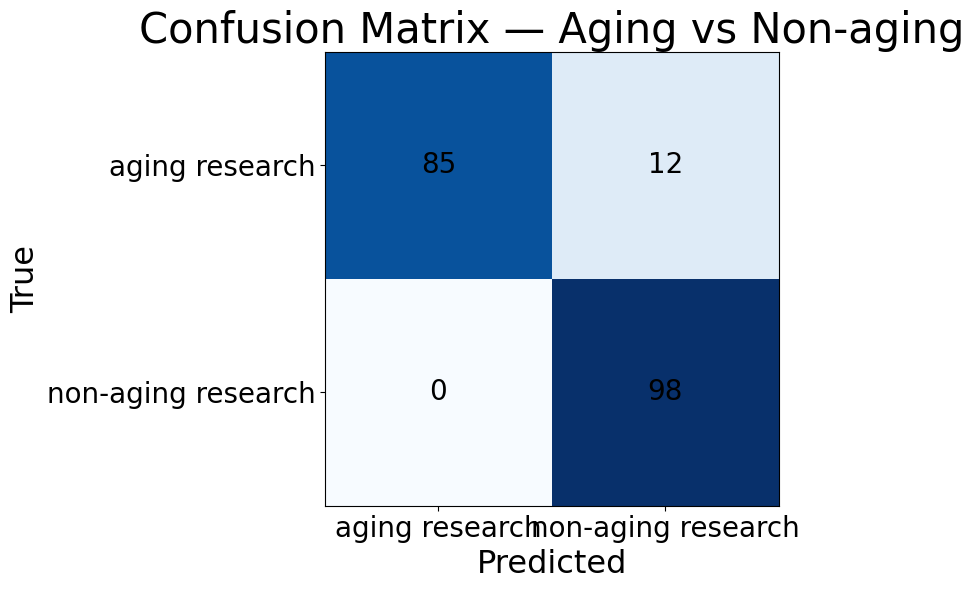

In [15]:
# =========================
# Cell 9 — confusion matrix (AGING vs NON-AGING only) + save pdf
# =========================
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Normalize
y_true = df_pred["aging"].astype(str).str.strip().str.lower()
y_pred = df_pred["pred_aging"].astype(str).str.strip().str.lower()

# Keep only binary aging / non-aging
valid_classes = ["aging research", "non-aging research"]
mask = y_true.isin(valid_classes) & y_pred.isin(valid_classes)

y_true = y_true[mask]
y_pred = y_pred[mask]

cm = confusion_matrix(y_true, y_pred, labels=valid_classes)

# Plot
plt.figure(figsize=(8, 6))

im = plt.imshow(cm, cmap="Blues")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=20)

plt.xticks([0, 1], valid_classes, fontsize=20)
plt.yticks([0, 1], valid_classes, fontsize=20)

plt.xlabel("Predicted", fontsize=23)
plt.ylabel("True", fontsize=23)
plt.title("Confusion Matrix — Aging vs Non-aging", fontsize=30)

plt.tight_layout()
plt.savefig("oss.pdf")
plt.show()


In [16]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report

# Use existing y_true / y_pred if present, otherwise derive from df_pred
try:
    yt = y_true
    yp = y_pred
except NameError:
    valid_classes = ["aging research", "non-aging research"]
    yt = df_pred["aging"].astype(str).str.strip().str.lower()
    yp = df_pred["pred_aging"].astype(str).str.strip().str.lower()
    mask = yt.isin(valid_classes) & yp.isin(valid_classes)
    yt = yt[mask]
    yp = yp[mask]

valid_classes = ["aging research", "non-aging research"]

precision, recall, f1, support = precision_recall_fscore_support(yt, yp, labels=valid_classes, zero_division=0)
acc = accuracy_score(yt, yp)
macro_f1 = f1.mean()
micro_p, micro_r, micro_f, _ = precision_recall_fscore_support(yt, yp, average='micro')

print(f"Accuracy: {acc:.3f}")
for cls, p, r, fn, s in zip(valid_classes, precision, recall, f1, support):
    print(f"{cls}: precision={p:.3f}, recall={r:.3f}, f1={fn:.3f}, support={s}")
print(f"Macro F1: {macro_f1:.3f}")
print(f"Micro F1: {micro_f:.3f}")

print("\nClassification report:\n", classification_report(yt, yp, labels=valid_classes, zero_division=0))

Accuracy: 0.938
aging research: precision=1.000, recall=0.876, f1=0.934, support=97
non-aging research: precision=0.891, recall=1.000, f1=0.942, support=98
Macro F1: 0.938
Micro F1: 0.938

Classification report:
                     precision    recall  f1-score   support

    aging research       1.00      0.88      0.93        97
non-aging research       0.89      1.00      0.94        98

          accuracy                           0.94       195
         macro avg       0.95      0.94      0.94       195
      weighted avg       0.95      0.94      0.94       195

